In [ ]:
!pip3 install numpy
!pip3 install matplotlib
!pip3 install pandas

!pip3 install opencv-python

!pip3 install torch torchvision torchaudio

!pip3 install tensorflow
!pip3 install keras
!pip3 install tensorflow

!pip3 install gTTS
!pip3 install audiomentations

In [1]:
from random import random
import time
import os
from pathlib import Path
from collections import Counter
from sklearn.model_selection import train_test_split

import cv2
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from torch.utils.data import Dataset
from torchvision.io import read_image
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

from gtts import gTTS # for text-to-speech
from scipy.io.wavfile import read, write
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift

In [2]:
# Make plots larger (default [6,4] on my machine)

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [12, 8]
# print(mpl.rcParams['figure.figsize'])

## Data Pre-Processing

In [3]:
# Data folder paths

datadir = Path("data/samples/")
# datadir_sharpened = Path("sharpened/samples/")

In [4]:
# Get images from data directory

images = list(datadir.glob("*.png")) # get images of format .png
print("Number of captcha images: ", len(images))

Number of captcha images:  1040


In [5]:
characters = set() # unique characters
captcha_size = [] # number of characters in each captcha
img_label_lst = [] # image-label info: list of tuples (image path, image label)

# Iterate over dataset
for img_path in images:
    label = img_path.name.split(".png")[0] # extract image label (name of file)
    captcha_size.append(len(label)) # length of this captcha
    img_label_lst.append((str(img_path), label))
    for ch in label: # store the characters present
        characters.add(ch)

characters = sorted(characters)
img_label_df = pd.DataFrame(img_label_lst, columns=["img_path", "label"], index=None) # convert to pd dataframe
img_label_df = img_label_df.sample(frac=1.).reset_index(drop=True) # shuffle the dataset

print("Number of captcha images: ", len(img_label_df))
img_label_df.head() # print top 5

Number of captcha images:  1040


,img_path,label
0,data/samples/8gf7n.png,8gf7n
1,data/samples/ec6pm.png,ec6pm
2,data/samples/8gmnx.png,8gmnx
3,data/samples/33b22.png,33b22
4,data/samples/bw6n6.png,bw6n6


### Removing Blur and Sharpening Images

(Optional)

In [6]:
print(img_label_df[img_label_df['label'] == '8n4n8'])
print(img_label_df.iloc[[0]]['img_path'])
testvar1234 = img_label_df['img_path'].values[0] # (img_label_df.iloc[[0]])['img_path']
print(testvar1234)
print(type(testvar1234))

                   img_path  label
377  data/samples/8n4n8.png  8n4n8
0    data/samples/8gf7n.png
Name: img_path, dtype: object
data/samples/8gf7n.png
<class 'str'>


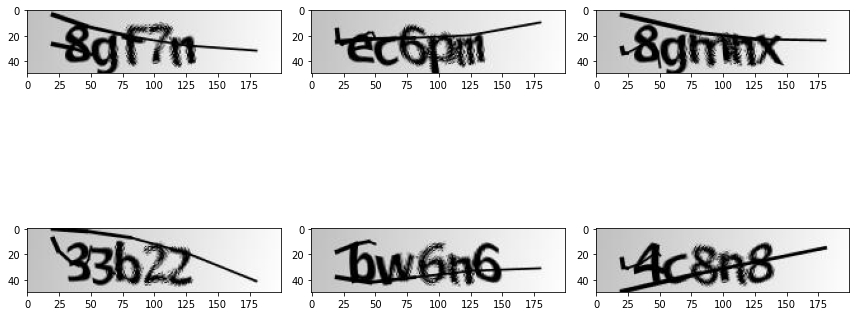

In [7]:
num_rows = 2
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols)

row = 0
for img_idx in range(0, 6, 1):
    # print(img_paths[img_index].shape)
    img = cv2.imread(img_label_df['img_path'].values[img_idx])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if img_idx % 3 == 0 and img_idx != 0:
        row += 1
    axes[row, img_idx % num_cols].imshow(img)
    # axes[row, img_index % num_cols].set_title(captcha_labels_train[img_index])

fig.tight_layout()
plt.show()

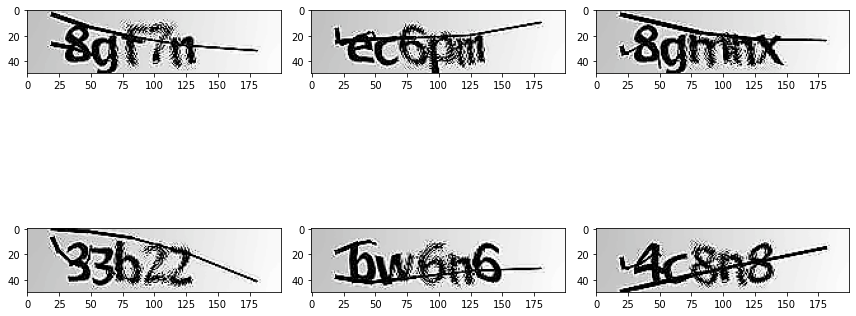

In [8]:
num_rows = 2
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols)

row = 0
for img_idx in range(0, 6, 1):
    img = cv2.imread(img_label_df['img_path'].values[img_idx])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # img = cv2.fastNlMeansDenoisingColored(img,None,10,10,7,21)

    sharpen_kernel = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]])
    sharpened_image = cv2.filter2D(img, -1, sharpen_kernel)
    sharpened_image = cv2.fastNlMeansDenoisingColored(sharpened_image,None,10,10,7,21)

    if img_idx % 3 == 0 and img_idx != 0:
        row += 1
    axes[row, img_idx % num_cols].imshow(sharpened_image)
    # axes[row, img_idx % num_cols].set_title(captcha_labels_train[img_idx])

fig.tight_layout()
plt.show()

The sharpening filter sharpens the edges of characters like '2', which were clear solid characters with soft edges in the sample.
However, it also accentuates the choppy edges in our captcha images. We are unable to remove this with the denoising filter since OpenCV sees it as relevant data, not noise.

Other sharpening filters seem to do the same.

So we will not use sharpening. However, the code is here in case we ever need to run the program on a different dataset

## Building the Dataloader

In [ ]:
class CaptchaModel(nn.Module):
    '''
    Neural Net to detect CAPTCHA label
    '''
    def __init__(self, data, labels, char_map, batch_size=16, img_width=200, img_height=50, downsample_factor=4, max_length=5, shuffle=True):
        super(CaptchaModel, self).__init__()

## Text-to-Speech

In [ ]:
from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech, SpeechT5HifiGan
from datasets import load_dataset
import torch
import soundfile as sf

processor = SpeechT5Processor.from_pretrained('microsoft/speecht5_tts')
model = SpeechT5ForTextToSpeech.from_pretrained('microsoft/speecht5_tts')
vocoder = SpeechT5HifiGan.from_pretrained('microsoft/speecht5_hifigan')

# inputs = processor(text="Work you stupid piece of crap", return_tensors="pt")
inputs = processor(text="C...A", return_tensors="pt")

embeddings_dataset = load_dataset("Matthijs/cmu-arctic-xvectors", split="validation")
speaker_embeddings = torch.tensor(embeddings_dataset[7306]["xvector"]).unsqueeze(0)

speech = model.generate_speech(inputs["input_ids"], speaker_embeddings, vocoder=vocoder)

from IPython.display import Audio

Audio(speech, rate=16000)
# sf.write("testAudio.wav")

In [ ]:
from gtts import gTTS 

text = 'C/A/8/n/4'
language = 'en'
myobj = gTTS(text=text, lang=language, slow=True) # slow=True for speech to be slow

myobj.save("welcome.mp3")

In [37]:
def label2speech(captcha_label:str, language:str='en'):
    txt = ""
    for character in captcha_label:
        txt += character + "/"
    speech_obj = gTTS(text=txt, lang=language, slow=True) # slow=True for speech to be slow
    # speech_obj.save("captchaAudioClean.wav")
    speech_obj.save("captchaAudioClean.mp3")
    sound = speech_obj.from_mp3("captchaAudioClean.mp3")
    sound.export("myfile.wav", format="wav")
    # write("captcha.wav", 44100, speech_obj)
    # tempWavFile = speech_obj.TemporaryFile(suffix="wav")
    # speech_obj.write_to_fp("captchaAudioClean123.wav")

    # clean_speech = read("captchaAudioClean.wav")
    # clean_speech_arr = np.array(clean_speech[1],dtype=float)
    # print(clean_speech_arr)
    # print(clean_speech_arr.size)
    # samplerate, data = read("captchaAudioClean.wav")

    # augment = Compose([
    #     AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    #     TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
    #     PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
    #     # Shift(min_fraction=-0.5, max_fraction=0.5, p=0.5),
    # ])

    # # Generate 2 seconds of dummy audio for the sake of example
    # samples = np.random.uniform(low=-0.2, high=0.2, size=(32000,)).astype(np.float32)

    # # Augment/transform/perturb the audio data
    # augmented_samples = augment(samples=samples, sample_rate=16000)
    # # augmented_samples.save("noise.wav")
    # write('test.wav', 44100, augmented_samples)

    return speech_obj

In [38]:
label2speech("Hello")

AttributeError: 'gTTS' object has no attribute 'dtype'

In [ ]:
augment = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
    # Shift(min_fraction=-0.5, max_fraction=0.5, p=0.5),
])

# Generate 2 seconds of dummy audio for the sake of example
samples = np.random.uniform(low=-0.2, high=0.2, size=(32000,)).astype(np.float32)

# Augment/transform/perturb the audio data
augmented_samples = augment(samples=samples, sample_rate=16000)
# augmented_samples.save("noise.wav")
from scipy.io.wavfile import write
write('test.wav', 44100, augmented_samples)

In [39]:
rate, data = read("test.wav")

In [41]:
from pydub import AudioSegment